## Ranjan et al. 2016 Implementation (Test Function 3: Franke)

https://github.com/EmuKit/emukit/blob/main/notebooks/Emukit-tutorial-Bayesian-optimization-introduction.ipynb

In [1]:
import numpy as np
true_param = np.array([7/9, 4/9]).reshape(1,2)

In [2]:
import emcee
from scipy.optimize import minimize
import corner
import ptemcee
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from emukit.core import ParameterSpace, ContinuousParameter
from GPy.models import MultioutputGP
from GPy import likelihoods
from emukit.model_wrappers import GPyMultiOutputWrapper
from GPy.kern import RBF, White
from GPy.kern.src.stationary import Matern32
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from GPy.models import GPRegression
import GPy

import random
random.seed(1)

from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop

from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from pyDOE import *
from scipy.stats import norm
from scipy import integrate
import corner

import math
%matplotlib inline 

from emcee.ptsampler import PTSampler
from sklearn.preprocessing import StandardScaler

# set seaborn style
import seaborn as sns
sns.set_style("white")

In [3]:
# 3d plot function
def makeplot(position,x,y,z,title):
    ax = fig.add_subplot(position,projection='3d')
    ax.scatter(x, y, z, c=z, label=title)
    ax.legend()
    return ax

In [4]:
lb = [0,0]
ub = [1,1]
parameter_space = ParameterSpace([ContinuousParameter('x1', lb[0], ub[0]),ContinuousParameter('x2', lb[1], ub[1])])
pi = math.pi
noise = 0.01 # statistical noise

def f(X): # with statistical noise
    term1 = 0.75 * np.exp(-(9*X[:,0]-2)**2/4 - (9*X[:,1]-2)**2/4)
    term2 = 0.75 * np.exp(-(9*X[:,0]+1)**2/49 - (9*X[:,1]+1)/10)
    term3 = 0.5 * np.exp(-(9*X[:,0]-7)**2/4 - (9*X[:,1]-3)**2/4)
    term4 = -0.2 * np.exp(-(9*X[:,0]-4)**2 - (9*X[:,1]-7)**2)
    y1 = term1 + term2 + term3 + term4 +  np.random.normal(0,noise,X.shape[0])
    return y1.reshape(-1,1)

def f_noNoise(X): # noise-free
    term1 = 0.75 * np.exp(-(9*X[:,0]-2)**2/4 - (9*X[:,1]-2)**2/4)
    term2 = 0.75 * np.exp(-(9*X[:,0]+1)**2/49 - (9*X[:,1]+1)/10)
    term3 = 0.5 * np.exp(-(9*X[:,0]-7)**2/4 - (9*X[:,1]-3)**2/4)
    term4 = -0.2 * np.exp(-(9*X[:,0]-4)**2 - (9*X[:,1]-7)**2)
    y1 = term1 + term2 + term3 + term4
    return y1.reshape(-1,1)

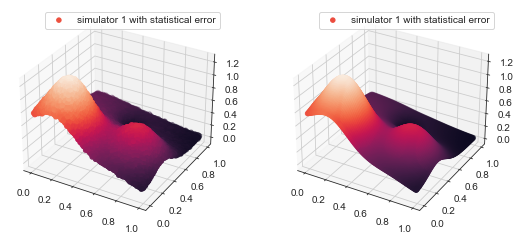

In [5]:
axis1 = np.arange(lb[0], ub[0], 0.01)
axis2 = np.arange(lb[1], ub[1], 0.01)

B, D = np.meshgrid(axis1, axis2)
X_plot = np.array([B.flatten(),D.flatten()]).transpose()
# side by side 3d plot
fig = plt.figure(figsize=(9,4))
makeplot(121, B.flatten(), D.flatten(), f(X_plot).flatten(), 'simulator 1 with statistical error')
makeplot(122, B.flatten(), D.flatten(), f_noNoise(X_plot).flatten(), 'simulator 1 with statistical error')
plt.show()

In [6]:
n_exp = 10
noise_exp = 0.02 # standard error

mu_exp = f_noNoise(true_param).flatten() # true function output
y_exp = np.random.normal(mu_exp, noise_exp, n_exp).reshape(-1,1) # uses scale, not variance
dy_exp = np.ones(1) * noise_exp

# parameters
mu_list = list(np.mean(y_exp, axis=0))
sigma_list = list(np.sqrt(np.var(y_exp, axis=0)))
print(mu_list, sigma_list)

[0.5060424258882914] [0.016549928664395874]


In [7]:
filename = 'Experimental Data/TF3_ExpData.txt'
np.savetxt(filename, y_exp)
filename = 'Experimental Data/TF3_dyExpData.txt'
np.savetxt(filename, dy_exp)

Target Posterior Distribution

In [8]:
theta_min = 0
theta_max = 1

# independent uniform prior
def log_flat_prior(theta):
    # The parameters are stored as a vector of values, so unpack them
    theta1, theta2 = theta
    # We're using only uniform priors in [0,1]
    if (theta_min <= theta1) and (theta1 <= theta_max) and (theta_min <= theta2) and (theta2 <= theta_max):
        return 0. # log(1)
    else:
        return -np.inf  # log(0)
    
# log_flat_prior = np.vectorize(log_flat_prior)

def sim_output(xx, obsno):
    """This generates output from simulator."""
    X = xx.reshape(-1, ndim)
    y = f(X)[obsno] # has noise
    return y

# define log likelihood
def log_likelihood_sim(theta, y_exp, dy_exp):
    '''
    Log-likelihood for data y_exp.
    theta: 2d vector;
    y_exp: n_exp by 2;
    dy_exp: 2d vector (experimental noise is the same for different observations).
    '''
    log_lik = 0
    for obs in range(y_exp.shape[1]): # number of observables
        y_pred = sim_output(theta, obs) # simulator (the same value for one input theta)
        sigma2 = dy_exp[obs]**2. + 0 # no simulator uncertainty
        log_lik = log_lik - 0.5*np.log(2.*np.pi*sigma2) - 0.5/sigma2 * np.sum((y_pred - y_exp[:,obs])**2)    
    return log_lik

#posterior using flat prior
def log_posterior_flat_prior_sim(theta, y_exp, dy_exp):
    '''Log posterior for data y_exp and uncertainties 
        dy_exp given parameter array theta, assuming prior is flat.'''
    return log_flat_prior(theta) + log_likelihood_sim(theta, y_exp, dy_exp)

In [9]:
# ptemcee
# https://emcee.readthedocs.io/en/develop/user/pt/
from emcee.ptsampler import PTSampler
ndim = 2
ntemps = 2
nwalkers = 20
# starting_guesses = np.ones(ntemps*nwalkers*ndim).reshape(ntemps,nwalkers,ndim)*0.5 + np.random.rand(ntemps,nwalkers,ndim) * 0.1
starting_guesses = np.random.uniform(low=theta_min, high=theta_max, size=(ntemps,nwalkers,ndim))
sampler = PTSampler(nwalkers, ndim, log_likelihood_sim, log_flat_prior, ntemps=ntemps, loglargs=[y_exp, dy_exp])

# burn in
for p, lnprob, lnlike in sampler.sample(starting_guesses, iterations=5000):
    pass
sampler.reset()

# record every 10
for p, lnprob, lnlike in sampler.sample(p, iterations=1000, thin=10):
    pass

# resulting chains
assert sampler.chain.shape == (ntemps, nwalkers, 100, ndim)

# Chain has shape (ntemps, nwalkers, nsteps, ndim)
# Zero temperature mean:
mu0 = np.mean(np.mean(sampler.chain[0,...], axis=0), axis=0)

# Longest autocorrelation length (over any temperature)
max_acl = np.max(sampler.acor)

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be int

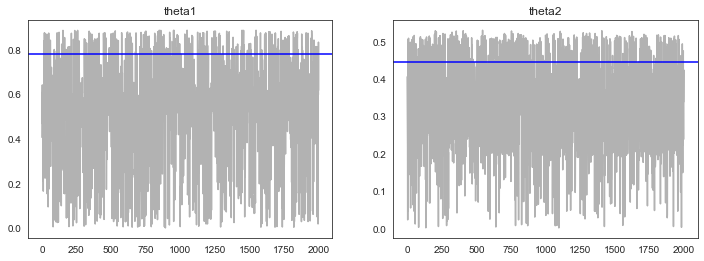

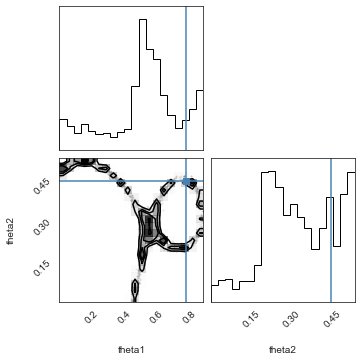

In [10]:
sim_T0chain = sampler.chain[0,...].reshape(-1,ndim)
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(sim_T0chain[:,0], '-', color='k', alpha=0.3)
ax1.axhline(y=true_param[0][0], color='blue')
ax1.title.set_text('theta1')

ax2.plot(sim_T0chain[:,1], '-', color='k', alpha=0.3)
ax2.axhline(y=true_param[0][1], color='blue')
ax2.title.set_text('theta2')
plt.show()

tmp = corner.corner(sim_T0chain, labels=['theta1','theta2'], 
                truths=[true_param[0][0],true_param[0][1]])

In [11]:
MCMC_sim = pd.DataFrame(sim_T0chain)
MCMC_sim.to_csv('Outputs/TF3_MCMCSim.csv', index=False)

Active Learning

In [12]:
def fw(X):
    term1 = 0.75 * np.exp(-(9*X[:,0]-2)**2/4 - (9*X[:,1]-2)**2/4)
    term2 = 0.75 * np.exp(-(9*X[:,0]+1)**2/49 - (9*X[:,1]+1)/10)
    term3 = 0.5 * np.exp(-(9*X[:,0]-7)**2/4 - (9*X[:,1]-3)**2/4)
    term4 = -0.2 * np.exp(-(9*X[:,0]-4)**2 - (9*X[:,1]-7)**2)
    Y1 = term1 + term2 + term3 + term4 +  np.random.normal(0,noise,X.shape[0])
    W1 = Y1**2 - 2*Y1*mu_list[0] + mu_list[0]**2 + sigma_list[0]**2.
    output = W1
    return output.reshape(-1,1)

In [13]:
axis1 = np.arange(lb[0], ub[0], 0.01)
axis2 = np.arange(lb[1], ub[1], 0.01)
B, D = np.meshgrid(axis1, axis2)
X_plot = np.array([B.flatten(),D.flatten()]).transpose()
w = fw(X_plot)
index_min = np.argmin(w)
X_plot[index_min,:]

array([0.  , 0.49])

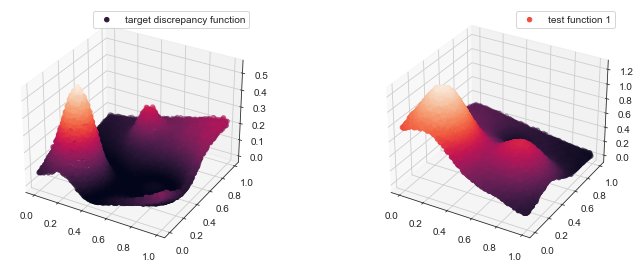

In [14]:
# side by side 3d plot
fig = plt.figure(figsize=(12,10))
makeplot(221, B.flatten(), D.flatten(), fw(X_plot), 'target discrepancy function')
makeplot(222, B.flatten(), D.flatten(), f(X_plot), 'test function 1')
plt.show()

In [15]:
### General imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

### --- Figure config
LEGEND_SIZE = 15

from emukit.test_functions import forrester_function
from emukit.core.loop.user_function import UserFunctionWrapper
from emukit.core import ContinuousParameter, ParameterSpace

from emukit.examples.gp_bayesian_optimization.single_objective_bayesian_optimization import GPBayesianOptimization
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement
from emukit.core.optimization import GradientAcquisitionOptimizer

In [16]:
n_init = 10
n_total = 35
Bayesian_Inference_Indicator = True

Iteration 0


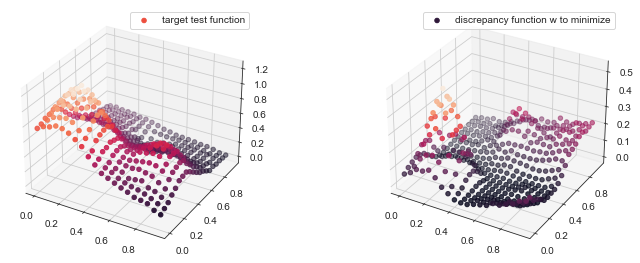

Iteration 1: x_new = [0. 0.]; EI = [0.22]
Iteration 2: x_new = [0.48 0.  ]; EI = [0.02]
Iteration 3: x_new = [0.   0.52]; EI = [0.01]
Iteration 4: x_new = [0.9  0.35]; EI = [0.02]
Iteration 5: x_new = [0.78 0.32]; EI = [0.01]
Iteration 6: x_new = [1.  0.5]; EI = [0.11]
Iteration 7: x_new = [0.   0.75]; EI = [0.22]
Iteration 8: x_new = [1.   0.16]; EI = [0.16]
Iteration 9: x_new = [0.63 0.  ]; EI = [0.05]
Iteration 10: x_new = [0.04 0.64]; EI = [0.02]
Iteration 11: x_new = [0.41 0.09]; EI = [0.01]
Iteration 12: x_new = [0. 1.]; EI = [0.11]
Iteration 13: x_new = [0.82 0.45]; EI = [0.]
Iteration 14: x_new = [0.82 0.41]; EI = [0.]
Iteration 15: x_new = [0.82 0.41]; EI = [0.]
Iteration 16: x_new = [0.82 0.41]; EI = [0.]
Iteration 17: x_new = [0.   0.55]; EI = [0.]
Iteration 18: x_new = [0.83 0.4 ]; EI = [0.]
Iteration 19: x_new = [0.84 0.4 ]; EI = [0.]
Iteration 20: x_new = [0.82 0.43]; EI = [0.]
Iteration 21: x_new = [0.83 0.42]; EI = [0.]
Iteration 22: x_new = [0.8 0.4]; EI = [0.]
Iterati

In [17]:
i = 0
# initial sample size
X = lhs(n=ndim, samples=n_init, criterion='maximin', iterations=10)
max_iterations = n_total - n_init
W = fw(X)

kernel1 = RBF(input_dim=2, ARD=True)
gpy_model = GPy.models.GPRegression(X, W, kernel1, noise_var=1e-10)
emukit_model = GPyModelWrapper(gpy_model)
print('Iteration ' + str(i))

# predict on a grid
axis1 = np.arange(lb[0], ub[0], 0.05)
axis2 = np.arange(lb[1], ub[1], 0.05)
B, D = np.meshgrid(axis1, axis2)
X_plot = np.array([B.flatten(),D.flatten()]).transpose()
mu_plot, var_plot = emukit_model.predict(X_plot)

# side by side 3d plot
fig = plt.figure(figsize=(12,10))
makeplot(221, B.flatten(), D.flatten(), f(X_plot), 'target test function')
makeplot(222, B.flatten(), D.flatten(), fw(X_plot), 'discrepancy function w to minimize')
plt.show()

#---# BO Procedure
for i in range(1,n_total-n_init):
    # define EI function
    ei_acquisition = ExpectedImprovement(emukit_model)
    ei_plot = ei_acquisition.evaluate(X_plot)

    # optimize EI function
    optimizer = GradientAcquisitionOptimizer(parameter_space)
    x_new, opt_acq = optimizer.optimize(ei_acquisition)

    # # plot target function, prediction and ei of last iteration
    # fig = plt.figure(figsize=(12,10))
    # makeplot(221, B.flatten(), D.flatten(), mu_plot, 'prediction')
    # makeplot(222, B.flatten(), D.flatten(), ei_plot, 'ei')
    # plt.show()
    print('Iteration ' + str(i) + ': x_new = ' + str(np.round(x_new.flatten(),2)) + '; EI = ' + str(np.round(opt_acq.flatten(),2)))

    # update emulator with additional point
    w_new = fw(x_new)
    X = np.append(X, x_new, axis=0)
    W = np.append(W, w_new, axis=0)
    emukit_model.set_data(X, W)

    mu_plot, var_plot = emukit_model.predict(X_plot)
        


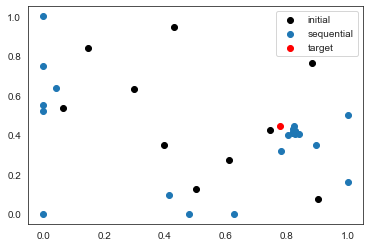

In [18]:
n_end = len(X)
fig, ax = plt.subplots()
ax.scatter(X[0:n_init,0],X[0:n_init,1], color='black', label='initial')
ax.scatter(X[n_init:n_end,0],X[n_init:n_end,1], label='sequential')
ax.scatter(true_param[:,0], true_param[:,1], color='red', label='target')
n = np.arange(0,X[0:n_end,:].shape[0])
# for i, txt in enumerate(n):
#     ax.annotate(txt, (X[i,0], X[i,1]))
plt.legend()

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be int

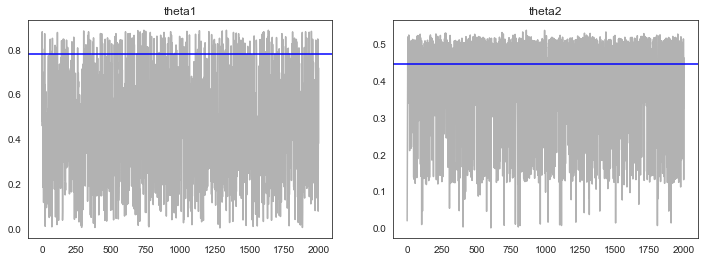

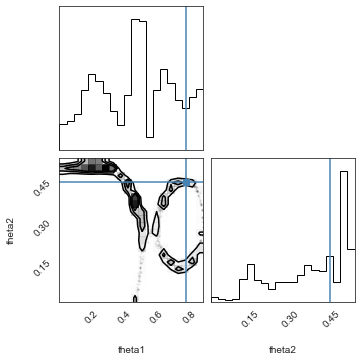

In [19]:
if Bayesian_Inference_Indicator == True:
    #---# Bayesian inference
    x_ranjan = X.copy() # no criterion specified: random design
    y_ranjan = f(x_ranjan)

    # train GP
    kernel1 = RBF(input_dim=2, ARD=True)
    model = GPy.models.GPRegression(x_ranjan, y_ranjan, kernel1, noise_var=1)
    model.optimize()

    def emu_predict(xx, obsno):
        """This function handles the scaling and GP interpolation together, 
        returning our prediction in the ordinary observable space
        rather than the scaled observable space.
        This map is what we call our 'emulator'. """
        X = xx.reshape(-1, ndim)
        new_column = [[obsno]]*len(X)
        pred_temp = model.predict(np.append(X,new_column,axis=1))
        y = pred_temp[0] # vector of predictive means
        s2_vec = pred_temp[1]
        dy = np.sqrt(s2_vec)
        return y, dy

    def log_likelihood(theta, y_exp, dy_exp):
        '''
        Log-likelihood for data y_exp.
        theta: 2d vector;
        y_exp: n_exp by 2;
        dy_exp: 2d vector (experimental noise is the same for different observations).
        '''
        #use our GP emulator for prediction
        log_lik = 0
        for obs in range(y_exp.shape[1]): # number of observables
            y_pred, s_pred = emu_predict(theta, obs) # emulator prediction and uncertainty
            sigma2 = dy_exp[obs]**2. + s_pred**2. # emulator uncertainty
            log_lik = log_lik - 0.5*np.log(2.*np.pi*sigma2) - 0.5/sigma2 * np.sum((y_pred - y_exp[:,obs])**2)    
        return log_lik

    #posterior using flat prior
    def log_posterior_flat_prior(theta, y_exp, dy_exp):
        '''Log posterior for data y_exp and uncertainties 
            dy_exp given parameter array theta, assuming prior is flat.'''
        return log_flat_prior(theta) + log_likelihood(theta, y_exp, dy_exp)

    # ptemcee
    ntemps = 2
    nwalkers = 20
    # starting_guesses = np.ones(ntemps*nwalkers*ndim).reshape(ntemps,nwalkers,ndim)*0.5 + np.random.rand(ntemps,nwalkers,ndim) * 0.1
    starting_guesses = np.random.uniform(size=(ntemps,nwalkers,ndim))
    sampler = PTSampler(nwalkers, ndim, log_likelihood, log_flat_prior, ntemps=ntemps, loglargs=[y_exp, dy_exp])

    # burn in
    for p, lnprob, lnlike in sampler.sample(starting_guesses, iterations=2000):
        pass
    sampler.reset()

    # record every 10
    for p, lnprob, lnlike in sampler.sample(p, iterations=1000, thin=10):
        pass

    # resulting chains
    assert sampler.chain.shape == (ntemps, nwalkers, 100, ndim)

    # Chain has shape (ntemps, nwalkers, nsteps, ndim)
    # Zero temperature mean:
    mu0 = np.mean(np.mean(sampler.chain[0,...], axis=0), axis=0)

    # Longest autocorrelation length (over any temperature)
    max_acl = np.max(sampler.acor)

    # plots & save data for R analysis
    prop_T0chain = sampler.chain[0,...].reshape(-1,ndim)
    fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    ax1.plot(prop_T0chain[:,0], '-', color='k', alpha=0.3)
    ax1.axhline(y=true_param[0][0], color='blue')
    ax1.title.set_text('theta1')

    ax2.plot(prop_T0chain[:,1], '-', color='k', alpha=0.3)
    ax2.axhline(y=true_param[0][1], color='blue')
    ax2.title.set_text('theta2')
    plt.show()

    tmp = corner.corner(prop_T0chain, labels=['theta1','theta2'], 
                    truths=[true_param[0][0],true_param[0][1]])

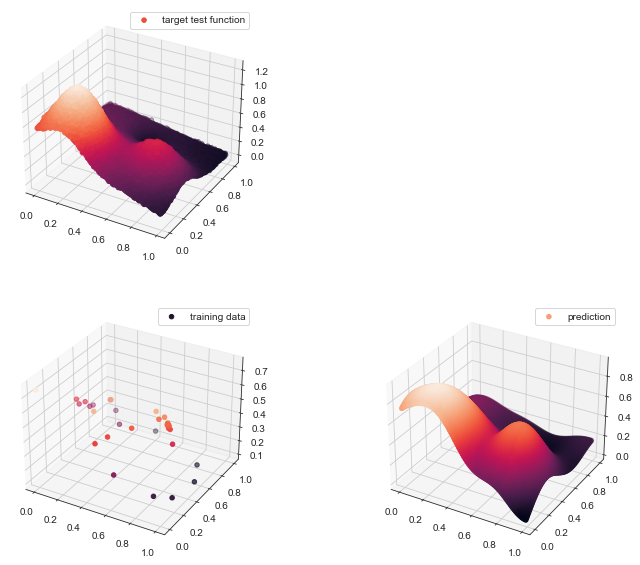

In [20]:
# predict on a grid
axis1 = np.arange(lb[0], ub[0], 0.01)
axis2 = np.arange(lb[1], ub[1], 0.01)
B, D = np.meshgrid(axis1, axis2)
X_plot = np.array([B.flatten(),D.flatten()]).transpose()
mu_plot, var_plot = model.predict(X_plot)

# side by side 3d plot
fig = plt.figure(figsize=(12,10))
makeplot(221, B.flatten(), D.flatten(), f(X_plot), 'target test function')
makeplot(223, x_ranjan[:,0], x_ranjan[:,1], y_ranjan, 'training data')
makeplot(224, B.flatten(), D.flatten(), mu_plot, 'prediction')
plt.show()

In [21]:
MCMC_sim = pd.DataFrame(prop_T0chain)
MCMC_sim.to_csv('Outputs/TF3_MCMCRanjan2016_init'+str(n_init)+'_seq'+str(n_total-n_init)+'.csv', index=False)

### Random LHD

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be int

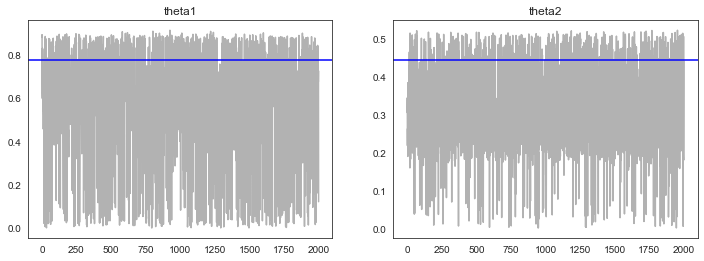

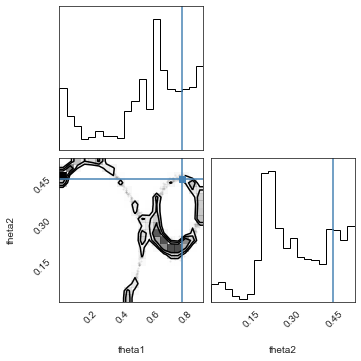

In [22]:
x_ref = lhs(n=2, samples=n_total) # no criterion specified: random design
y_ref = f(x_ref)

# train GP
kernel1 = RBF(input_dim=2, ARD=True)
model = GPy.models.GPRegression(x_ref, y_ref, kernel1, noise_var=1e-4)
model.optimize()

def emu_ref_predict(xx, obsno):
    """This function handles the scaling and GP interpolation together, 
    returning our prediction in the ordinary observable space
    rather than the scaled observable space.
    This map is what we call our 'emulator'. """
    X = xx.reshape(-1, ndim)
    new_column = [[obsno]]*len(X)
    pred_temp = model_ref.predict(np.append(X,new_column,axis=1))
    y = pred_temp[0] # vector of predictive means
    s2_vec = pred_temp[1]
    dy = np.sqrt(s2_vec)
    return y, dy

# define log likelihood
def log_likelihood_ref(theta, y_exp, dy_exp):
    '''
    Log-likelihood for data y_exp.
    theta: 2d vector;
    y_exp: n_exp by 2;
    dy_exp: 2d vector (experimental noise is the same for different observations).
    '''
    #use our GP emulator for prediction
    log_lik = 0
    for obs in range(y_exp.shape[1]): # number of observables
        y_pred, s_pred = emu_predict(theta, obs) # emulator prediction and uncertainty
        sigma2 = dy_exp[obs]**2. + s_pred**2. # emulator uncertainty
        log_lik = log_lik - 0.5*np.log(2.*np.pi*sigma2) - 0.5/sigma2 * np.sum((y_pred - y_exp[:,obs])**2)    
    return log_lik

#posterior using flat prior
def log_posterior_flat_prior_ref(theta, y_exp, dy_exp):
    '''Log posterior for data y_exp and uncertainties 
        dy_exp given parameter array theta, assuming prior is flat.'''
    return log_flat_prior(theta) + log_likelihood_ref(theta, y_exp, dy_exp)


# ptemcee
# https://emcee.readthedocs.io/en/develop/user/pt/
ntemps = 2
nwalkers = 20
# starting_guesses = np.ones(ntemps*nwalkers*ndim).reshape(ntemps,nwalkers,ndim)*0.5 + np.random.rand(ntemps,nwalkers,ndim) * 0.1
starting_guesses = np.random.uniform(size=(ntemps,nwalkers,ndim))
sampler = PTSampler(nwalkers, ndim, log_likelihood_ref, log_flat_prior, ntemps=ntemps, loglargs=[y_exp, dy_exp])

# burn in
for p, lnprob, lnlike in sampler.sample(starting_guesses, iterations=5000):
    pass
sampler.reset()

# record every 10
for p, lnprob, lnlike in sampler.sample(p, iterations=1000, thin=10):
    pass

# resulting chains
assert sampler.chain.shape == (ntemps, nwalkers, 100, ndim)

# Chain has shape (ntemps, nwalkers, nsteps, ndim)
# Zero temperature mean:
mu0 = np.mean(np.mean(sampler.chain[0,...], axis=0), axis=0)

# Longest autocorrelation length (over any temperature)
max_acl = np.max(sampler.acor)


# plots & save data for R analysis
LHD_T0chain = sampler.chain[0,...].reshape(-1,ndim)
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(LHD_T0chain[:,0], '-', color='k', alpha=0.3)
ax1.axhline(y=true_param[0][0], color='blue')
ax1.title.set_text('theta1')

ax2.plot(LHD_T0chain[:,1], '-', color='k', alpha=0.3)
ax2.axhline(y=true_param[0][1], color='blue')
ax2.title.set_text('theta2')
plt.show()

tmp = corner.corner(LHD_T0chain, labels=['theta1','theta2'], 
                truths=[true_param[0][0],true_param[0][1]])

MCMC_LHD = pd.DataFrame(LHD_T0chain)
MCMC_LHD.to_csv('Outputs/TF3_MCMCLHD_total'+str(n_total)+'.csv', index=False)